**Студент: Разуев Г.А.**
<br>
**Группа:  КЭ - 403**

# Задание

1. Разработайте программу, которая выполняет классификацию заданного набора данных с помощью дерева решений. Параметрами программы являются набор данных, критерий выбора атрибута разбиения (Information gain, Gain ratio, Gini index).

2. Проведите эксперименты на наборе Census Income (данные о результатах переписи населения, в т.ч. о годовом доходе -- ниже или выше $50000. В качестве обучающей выборки для построения дерева используйте 100% исходных данных.

3. Выполните визуализацию построенных деревьев решений.

4. Доработайте программу, добавив в список ее параметров долю, которую занимает обучающая выборка от общего размера набора данных, и обеспечив вычисление и выдачу в качестве результатов следующих показателей качества классификации: аккуратность (accuracy), точность (precision), полнота (recall), F-мера.

5. Проведите эксперименты на наборе данных, фиксируя критерий выбора атрибута разбиения и варьируя соотношение мощностей обучающей и тестовой выборок от 60%:40% до 90%:10% с шагом 10%.

6. Выполните визуализацию полученных результатов в виде следующих диаграмм:
    * построенные деревья решений для заданного набора данных;
    * показатели качества классификации в зависимости от соотношения мощностей обучающей и тестовой выборок для заданного набора данных.

7. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами: 
    * формулировка задания; 
    * гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами; 
    * рисунки с результатами визуализации;  
    * пояснения, раскрывающие смысл полученных результатов.

# 1. Реализация алгоритма

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from typing import List
import os
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [46]:
from sklearn.model_selection import train_test_split  # Импортируем функцию для разделения данных
from sklearn.tree import DecisionTreeClassifier, plot_tree    # Импортируем класс для построения дерева решений
from sklearn.metrics import classification_report, confusion_matrix  # Импортируем функции для оценки модели
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from typing import Any, Tuple, Literal, get_args  # Импортируем Any для аннотации типов данных

In [47]:
Criterions = Literal['gini', 'info_gain', 'gain_ratio']


class DecisionTreeModel:
    _sklear_name_criterions = {
        'gini': 'gini', 'info_gain': 'entropy', 'gain_ratio': 'log_loss'
    }

    def __init__(self, criterion: Criterions = 'gini',  random_state: int = 42, **kwarg) -> None:
        """
        Инициализация класса DecisionTreeModel.

        :param data: Входной DataFrame с данными
        :param target_column: Название колонки с целевой переменной
        :param criterion: Критерий разбиения для дерева решений, по умолчанию 'gini'
        """
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

        self.preprocessed_X_train = None
        self.preprocessed_X_test = None

        self.accuracy = None
        self.precision = None  # average='weighted' для многоклассовой классификации
        self.recall = None
        self.f1_score = None

        self.data_preprocessor = None

        self.set_criterion(criterion)  # Сохранение критерия разбиения
        self.classifier = DecisionTreeClassifier(criterion=self.criterion, **kwarg)  # Инициализация классификатора
        self.random_state = random_state  # Сохранение случайного состояния для воспроизводимости

    def fit(self,X: pd.DataFrame, y: pd.Series, test_size: float = 0.2, verbose: bool = False, sample_weight=None) -> DecisionTreeClassifier:
        """
        Обучение модели на обучающей выборке.
        
        :param test_size: Доля тестовой выборки
        :param random_state: Случайное состояние для воспроизводимости
        """
        X = X.copy()
        y = y.copy()
                    

        if test_size == 0:
            self.X_train = X
            self.y_train = y

            data_preprocessor, cat_cols = self._create_data_preporcessor(X)
            preprocessed_X = self._preprocess_data(X, data_preprocessor, cat_cols)
            self.data_preprocessor = data_preprocessor
            self.preprocessed_X_train = preprocessed_X
            
            self.classifier.fit(preprocessed_X, y, sample_weight=sample_weight)
            return self.classifier
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=self.random_state)
        data_preprocessor, cat_cols = self._create_data_preporcessor(X_train)

        preprocessed_X_train = self._preprocess_data(X_train, data_preprocessor, cat_cols, fitted=False)
        preprocessed_X_test = self._preprocess_data(X_test, data_preprocessor, cat_cols, fitted=True)

        self.data_preprocessor = data_preprocessor
        self.preprocessed_X_train = preprocessed_X_train
        self.preprocessed_X_test = preprocessed_X_test

        # Обучаем модель на обучающей выборке
        self.classifier.fit(preprocessed_X_train, y_train, sample_weight=sample_weight)

        # Делаем предсказания на тестовой выборке
        y_pred = self.classifier.predict(preprocessed_X_test)

        self.accuracy = accuracy_score(y_test, y_pred)
        self.precision = precision_score(y_test, y_pred, average='micro') 
        self.recall = recall_score(y_test, y_pred, average='micro')
        self.f1_score = f1_score(y_test, y_pred, average='micro')

        if verbose:
            print("\nОтчет о классификации:")
            print(classification_report(y_test, y_pred))

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """
        Прогнозирование на основе новой выборки.

        :param new_data: Набор данных для прогнозирования
        :return: Предсказанные классы
        """
        return self.classifier.predict(X)

    def set_criterion(self, new_criterion: Criterions) -> None:
        """
        Установка нового критерия разбиения.

        :param new_criterion: Новый критерий разбиения
        """
        if new_criterion not in get_args(Criterions):
            raise ValueError(f"Неизвестный критерий {new_criterion}")
        self.criterion = self._sklear_name_criterions.get(new_criterion)
        self.classifier = DecisionTreeClassifier(criterion=self.criterion)  # Пересоздаем классификатор с новым критерием

    def visualize_tree(self) -> None:
        """
        Визуализация дерева решений.
        """
        plt.figure(figsize=(12, 8))  # Задаем размер графика
        plot_tree(self.classifier, filled=True, feature_names=self.preprocessed_X_train.columns,
                class_names=list(self.classifier.classes_.astype(str)))
        plt.title('Дерево решений')
        plt.show()

    def _create_data_preporcessor(self, data) -> Tuple[ColumnTransformer, List[str]]:
        num_columns = data.select_dtypes(include=np.number).columns
        cat_columns = data.select_dtypes(include="object").columns

        num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
        cat_transformer = Pipeline(steps=[("OHE", OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

        data_preprocessor = ColumnTransformer(transformers=[("num_transformer", num_transformer, num_columns),
                                                            ("cat_transformer", cat_transformer, cat_columns)],
                                            remainder="passthrough")
        return data_preprocessor, cat_columns
    
    def _preprocess_data(self, data, data_preprocessor, cat_columns, fitted: bool = False) -> pd.DataFrame:
        if fitted:
            preprocessed_data = data_preprocessor.transform(data)
        else:
            preprocessed_data = data_preprocessor.fit_transform(data)
        # return preprocessed_data
        # print(type(preprocessed_data))
        # print(cat_columns)

        new_num_names = data_preprocessor.transformers_[0][2].copy()  # Копируем имена числовых колонок
        if len(cat_columns) != 0:
            new_cat_names = data_preprocessor.named_transformers_['cat_transformer'].get_feature_names_out(cat_columns)
            new_names = np.concatenate((new_num_names, new_cat_names))
        else:
            new_names = np.array(new_num_names)
        # print(preprocessed_data.shape)
        preprocessed_data = pd.DataFrame(preprocessed_data, columns=new_names)
        return preprocessed_data

    def _preprocess_splitted_X(self, X_train, X_test):
        train_preprocessor, train_cat_columns = self._create_data_preporcessor(X_train)
        X_train_preprocessed = self._preprocess_data(X_train, train_preprocessor, train_cat_columns)
        self.preprocessed_X_train =  X_train_preprocessed

        test_preprocessor, test_cat_columns = self._create_data_preporcessor(X_test)
        X_test_preprocessed = self._preprocess_data(X_test, test_preprocessor, test_cat_columns)
        self.preprocessed_X_test =  X_test_preprocessed

        return X_train_preprocessed, X_test_preprocessed



In [48]:
from sklearn.datasets import load_iris  # Импортируем набор данных Ирис
iris = load_iris()  

X = pd.DataFrame(data=iris.data, columns=iris.feature_names)  # Создаем DataFrame
y = pd.Series(iris.target)  # Добавляем целевую переменную

In [49]:
pd.concat([X, y], axis=1).rename(columns={0: 'target'}).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [50]:
# Создаем экземпляр класса DecisionTreeModel с критерием 
model = DecisionTreeModel(criterion='gini')
# Обучение модели
model.fit(X, y, verbose=True)


Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [51]:
# Создаем экземпляр класса DecisionTreeModel с критерием 
model = DecisionTreeModel(criterion='info_gain')
# Обучение модели
model.fit(X, y, verbose=True)


Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [52]:
# Создаем экземпляр класса DecisionTreeModel с критерием 
model = DecisionTreeModel(criterion='gain_ratio')
# Обучение модели
model.fit(X, y, test_size=0.7, verbose=True)


Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.90      0.85      0.88        33
           2       0.85      0.91      0.88        32

    accuracy                           0.92       105
   macro avg       0.92      0.92      0.92       105
weighted avg       0.92      0.92      0.92       105



# 2. Эксперименты

 ## Загрузка данных 



Данные были извлечены из базы данных бюро переписи населения, доступной по адресу: [census.gov](http://www.census.gov/ftp/pub/DES/www/welcome.html). 

- **Количество экземпляров**: 48,842 (обучающая выборка: 32,561; тестовая выборка: 16,281)
- **Целевая задача**: Предсказать, зарабатывает ли человек более 50K в год.
- **Вероятности классов**:
  - Для метки '>50K': 23.93%
  - Для метки '<=50K': 76.07%

## Признаки:

1. **age**: непрерывный
2. **workclass**: 
   - Private
   - Self-emp-not-inc
   - Self-emp-inc
   - Federal-gov
   - Local-gov
   - State-gov
   - Without-pay
   - Never-worked
3. **fnlwgt**: непрерывный (конечный вес)
4. **education**: 
   - Бакалавр
   - Некоторый колледж
   - 11 класс
   - Высшее образование
   - Профессиональная школа
   - Ассоциированный (академический и профессиональный)
   - 9 класс
   - 7-8 класс
   - 12 класс
   - Магистр
   - 1-4 класс
   - 10 класс
   - Докторская степень
   - 5-6 класс
   - Детский сад
5. **education-num**: непрерывный
6. **marital-status**: 
   - Женат (гражданский супруг)
   - Разведен
   - Никогда не женат
   - Раздельно живущий
   - Вдова
   - Женат, супруг отсутствует
   - Женат на супруге военнослужащего
7. **occupation**: 
   - Техническая поддержка
   - Ремесло
   - Другие услуги
   - Продажи
   - Исполнительный менеджер
   - Профессиональная специальность
   - Уборщики
   - Диспетчеры
   - Административный работник
   - Сельское хозяйство и рыбалка
   - Транспорт и перемещение
   - Обслуживание частных домов
   - Защита
   - Военные
8. **relationship**: 
   - Жена
   - Ребенок
   - Муж
   - Не в семье
   - Другой родственник
   - Не состоящий в браке
9. **race**: 
   - Белый
   - Азиатско-Тихоокеанский островитянин
   - Американец-эскимос
   - Другие
   - Черный
10. **sex**: 
    - Женский
    - Мужской
11. **capital-gain**: непрерывный
12. **capital-loss**: непрерывный
13. **hours-per-week**: непрерывный
14. **native-country**: Страны с различными названиями (например, США, Канада, Германия и др.)

## Изменения в данных:
- Данные были дискретизированы по доходу с порогом в 50,000.
- Ненужные символы были заменены (например, "U.S." на "US").
- Пропущенные значения заменены на "Unknown".

## Примечания:
Данные были извлечены в 1994 году на основе условий для выборки, чтобы избежать отсутствующих и конфликтующих записей.

In [53]:
DATA_PATH = 'data'
data_columns = [
    'age',               # Возраст (непрерывный)
    'workclass',        # Класс работы
    'fnlwgt',           # Конечный вес (непрерывный)
    'education',        # Образование
    'education-num',    # Номер образования (непрерывный)
    'marital-status',   # Семейное положение
    'occupation',       # Занятость
    'relationship',     # Родственные отношения
    'race',             # Раса
    'sex',              # Пол
    'capital-gain',     # Прибыль от капитала (непрерывный)
    'capital-loss',      # Убыток от капитала (непрерывный)
    'hours-per-week',   # Часы работы в неделю (непрерывный)
    'native-country',    # Страна происхождения
    'target'            # Доход (целевой признак: '>50K' или '<=50K')
]

In [54]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'),  header=None)
train.columns = data_columns

In [55]:
train.shape

(32561, 15)

In [56]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [57]:
train.isna().sum().sum()

0

In [58]:
train.target = train.target.str.strip().replace({'<=50K': 0, '>50K': 1})

C:\Users\george\AppData\Local\Temp\ipykernel_1868\2278690674.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [59]:
pd.merge(
    train.target.value_counts().to_frame().reset_index(),
    train.target.value_counts(normalize=True).mul(100).round(2).to_frame().reset_index(),
    on='target'
)


,target,count,proportion
0,0,24720,75.92
1,1,7841,24.08


In [60]:
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'),  header=None, skiprows=1)
test.columns = data_columns

In [61]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [62]:
test.shape

(16281, 15)

In [63]:
test.target.unique()

array([' <=50K.', ' >50K.'], dtype=object)

In [64]:
test.target = test.target.str.strip().replace({'<=50K.': 0, '>50K.': 1})

C:\Users\george\AppData\Local\Temp\ipykernel_1868\167773820.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [65]:
pd.merge(
    test.target.value_counts().to_frame().reset_index(),
    test.target.value_counts(normalize=True).mul(100).round(2).to_frame().reset_index(),
    on='target'
)

,target,count,proportion
0,0,12435,76.38
1,1,3846,23.62


In [66]:
full_df = pd.concat([train, test])

In [67]:
full_df.shape

(48842, 15)

## Эксперименты с полным набором данных

In [68]:
# Создаем экземпляр класса DecisionTreeModel с критерием 
model = DecisionTreeModel(criterion='gain_ratio', max_depth=3)
# Обучение модели
model.fit(full_df.drop(columns=['target']), y=full_df.target, test_size=0, verbose=True)

DecisionTreeClassifier(criterion='log_loss', max_depth=3)

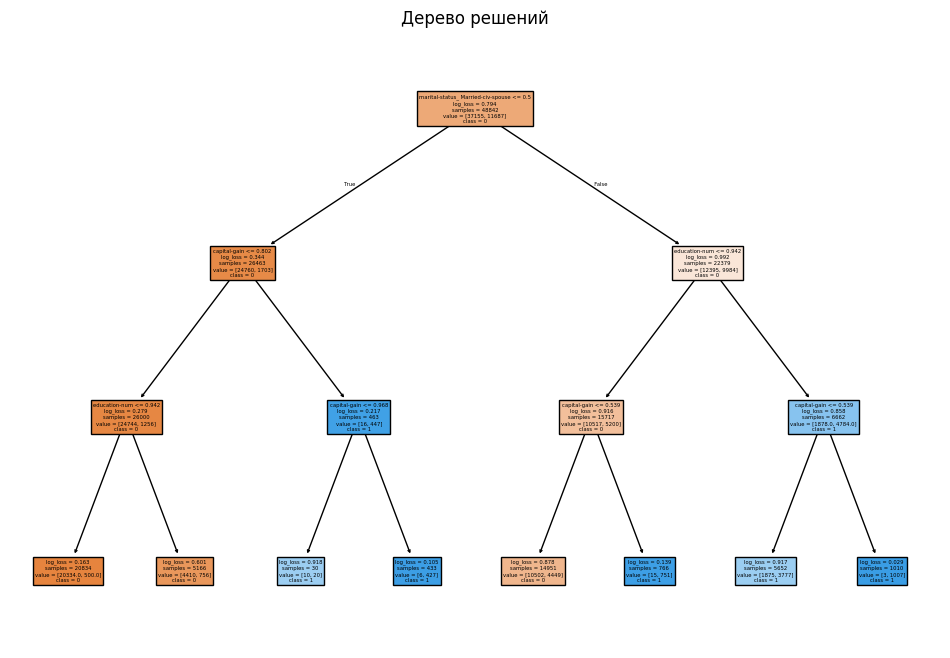

In [69]:
model.visualize_tree()

## Эксперименты с разными параметрами

In [70]:
criteria = list(get_args(Criterions))

# Хранение результатов
results = {criterion: {"accuracy": [], "precision": [], "recall": [], "f1_score": []} for criterion in criteria}
test_sizes = np.arange(0.1, 0.5, 0.1)  # От 10% до 40%

In [71]:
for criterion in criteria:
    model = DecisionTreeModel(criterion)
    for test_size in test_sizes:
        _ = model.fit(full_df.drop(columns=['target']), full_df['target'], test_size=test_size)

        # Сохранение метрик
        results[criterion]["accuracy"].append(model.accuracy)
        results[criterion]["precision"].append(model.precision)
        results[criterion]["recall"].append(model.recall)
        results[criterion]["f1_score"].append(model.f1_score)

        # Визуализация дерева решений для каждой конфигурации
        # Код останеся закомментированым, приведен только для формлаьного соблюдения задания
        # model.visualize_tree()

In [72]:
# Функция для создания графиков
def create_plot(x, y_data, title, y_label):
    fig = go.Figure()
    for label, data in y_data.items():
        fig.add_trace(go.Scatter(x=x, y=data, mode='lines+markers+text', name=label, text=list(map(lambda x: f'{x:.2f}', data))))

    fig.update_layout(title=title,
                      xaxis_title='Test Size',
                      yaxis_title=y_label,
                      legend_title='Criterion',
                      template='plotly_white')
    
    return fig

test_sizes_labels = list(map(lambda x: f'{round(x* 100 )} %', test_sizes))

In [73]:
accuracy_fig = create_plot(test_sizes_labels, {k: results[k]['accuracy'] for k in results}, 'Accuracy', 'Accuracy')
accuracy_fig.show()

In [75]:
accuracy_fig = create_plot(test_sizes_labels, {k: results[k]['precision'] for k in results}, 'Precision', 'Precision')
accuracy_fig.show()

In [76]:
# Показатель качества: Recall
recall_fig = create_plot(test_sizes_labels, {k: results[k]['recall'] for k in results}, 'Recall', 'Recall')
recall_fig.show()

In [77]:
# Показатель качества: F1 Score
f1_fig = create_plot(test_sizes_labels, {k: results[k]['f1_score'] for k in results}, 'F1 Score', 'F1 Score')
f1_fig.show()